# Rice Leaf Diseases: Implementing a Custom Model - Part 2
## Using Transfer Learning to "warm up" our model's weights.

This notebook will continue our exploration of the [Rice Leaf Diseases dataset from Kaggle](https://www.kaggle.com/vbookshelf/rice-leaf-diseases).  

In this notebook, we will do the following:

1. Create a CNN-based classifier network similar to [1], as we did in the previous notebook.
2. Load pre-trained weights for transfer learning.  The model was pre-trained on the "Plant Leaves" dataset available at [2].
3. Specialize the network on our rice image dataset (training partition), using lots of image augmentation to prevent overfitting.
4. Predict on the testing partition, and display results with a confusion matrix and classification report.

[1]: Wick, C. & Puppe, F. Leaf Identification Using a Deep Convolutional Neural Network. arXiv:1712.00967 [cs] (2017).

[2]: CHOUHAN, Siddharth Singh; Kaul, Ajay; SINGH, UDAY PRATAP; Madhav Institute of Technology & Science  (2019), “A Database of Leaf Images: Practice towards Plant Conservation with Plant Pathology”, Mendeley Data, V1, doi: 10.17632/hb74ynkjcn.1 <https://data.mendeley.com/datasets/hb74ynkjcn/1>

## Setting up your environment
Before running this notebook, you will need to make sure you have [downloaded](https://www.kaggle.com/vbookshelf/rice-leaf-diseases) the dataset and extracted the files.  This notebook assumes the image data is extracted in the same directory as this notebook, and that the top-level data directory is named "rice_leaf_diseases".  You can edit the code if those assumptions do not hold on your own setup.

## Python environment
You will need the following packages installed to execute the code shown in this notebook:

* [Matplotlib](https://matplotlib.org/)
* [Numpy](https://numpy.org/)
* [Pandas](https://pandas.pydata.org/)
* [Scikit-Learn](https://scikit-learn.org/)
* [Tensorflow](https://www.tensorflow.org/)

## Local directory structure
This notebook assumes you have the rice leaf images in the following directory structure:

    rice_leaf_diseases/
        Bacterial leaf blight/
        Brown spot/
        Leaf smut/

The "ground truth" file "_rice_leaf_diseases_ground_truth.csv_" was created in the previous ("rice_image_EDA") notebook.  If you don't have this file, you can create it by running the first several cells in that notebook, which is available [by clicking here](https://gist.github.com/jcausey-astate/207ba4d65126abe0482b740b41117f9e).

The pre-trained weights we will be using are available at: <TODO-LINK-HERE>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import sklearn.metrics as metrics
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

First, we will create a function that will actually define the structure of the network.  We use Wick et al. (2017) as a guide, and fill in the missing details with common choices (activations, amount of dropout, etc.).

In [2]:
def build_leaf_classifier_model(input_shape=(256,256,3), n_classes=3):
    '''
    This function builds a Keras CNN similar to the one described in Wick et al. (2017).
    '''
    lrelu = keras.layers.LeakyReLU()
    input = keras.layers.Input(shape=input_shape)
    x = keras.layers.Conv2D(40, (3,3), activation=lrelu, padding='same', name="conv1")(input)
    x = keras.layers.MaxPool2D((2,2), name='max_pool1')(x)
    x = keras.layers.Conv2D(40, (4,4), activation=lrelu, padding='same', name='conv2')(x)
    x = keras.layers.MaxPool2D((2,2), name='max_pool2')(x)
    x = keras.layers.Conv2D(80, (4,4), activation=lrelu, padding='same', name='conv3')(x)
    x = keras.layers.MaxPool2D((2,2), name='max_pool3')(x)
    x = keras.layers.Conv2D(160, (4,4), activation=lrelu, padding='same', name='conv4')(x)
    x = keras.layers.MaxPool2D((2,2), name='max_pool4')(x)
    x = keras.layers.Flatten(name='flatten')(x)
    x = keras.layers.Dense(500, activation=lrelu, name='dense_feature')(x)
    x = keras.layers.Dropout(0.20, name='dropout1')(x)
    x = keras.layers.Dense(n_classes, activation='softmax', name='dense_output')(x)
    return keras.Model(inputs=input, outputs=x)

Let's create an instance of the model and see the summary:

In [3]:
plant_leaves_model = build_leaf_classifier_model(n_classes=22) # Need 22 classes for pre-trained model
plant_leaves_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 256, 40)      1120      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 128, 128, 40)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 128, 40)      25640     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 64, 64, 40)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 64, 64, 80)        51280     
_________________________________________________________________
max_pool3 (MaxPooling2D)     (None, 32, 32, 80)        0     

## Load the pre-trained weights from the Plant Leaves dataset:

In [4]:
plant_leaves_weights = "plant_leaves_weights_30-0.35.h5"
plant_leaves_model.load_weights(plant_leaves_weights)

## Customize the model for our rice data:
We need to replace the classifier layer, creating a rice leaf model.  We will add one hidden layer (a Dense layer with 64 units) and an output layer to give us probabilities for our 3 classes.  These will receive the output from the feature layer in the pre-trained model (which has 500 units).

In [5]:
# Replace the classifier layer, creating a rice leaf model:
plant_feature_layer = plant_leaves_model.get_layer("dense_feature").output
new_features_layer = keras.layers.Dense(64, activation='relu', name="rice_features")(plant_feature_layer)
new_output_layer = keras.layers.Dense(3, activation='softmax', name="rice_outputs")(new_features_layer)
rice_disease_model = keras.Model(
    inputs=plant_leaves_model.input,
    outputs=new_output_layer
)

In [6]:
rice_disease_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 256, 40)      1120      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 128, 128, 40)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 128, 40)      25640     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 64, 64, 40)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 64, 64, 80)        51280     
_________________________________________________________________
max_pool3 (MaxPooling2D)     (None, 32, 32, 80)        0   

This model has almost 21 million parameters, but we have already trained most of them (all except the $32,064 + 195 = 32,259$ parameters from the new feature and output layers).  

We will fit those ~32K new weights on a training dataset, with augmentation.

Let's load the dataset and use `StratifiedShuffleSplit` to create an 80/20 train/test split:

In [7]:
ground_truth_df = pd.read_csv("rice_leaf_diseases_ground_truth.csv")
ground_truth_df.head()
sss = StratifiedShuffleSplit(1, test_size=0.20, random_state=2021)
train_indices, test_indices = list(sss.split(ground_truth_df.values, ground_truth_df['class'].values))[0]
print(f"Training set has {train_indices.shape[0]} samples.")
print(f"Test set has {test_indices.shape[0]} samples.")

Training set has 96 samples.
Test set has 24 samples.


Now we will set up our image data generators for training and testing.

The training generator will not do any augmentation.  It will only scale the image to contain values in the $[0,1]$ numeric range.

The test generator will perform several kinds of augmentation, in addition to rescaling the image to $[0,1]$: 



In [8]:
# Declare the generator (we will take default initial paramters for now)
test_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0
)
train_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=60,
    width_shift_range=0.20,
    height_shift_range=0.10,
    zoom_range=0.2,
    brightness_range=(0.5, 1.25),
)

Now, we will create a "flow" (this is actually the seqeunce of data that will feed the model).  We want one for training that uses only the "train" rows in the ground truth dataframe, and one for testing that uses only the "test" rows.  The training flow will be shuffled, the testing one need not be, so we won't.

In [9]:
BATCH_SIZE = 32
train_dataflow = train_generator.flow_from_dataframe(
    ground_truth_df.iloc[train_indices,:],
    x_col = "image_path",
    y_col = "class",
    target_size = (256,256),
    shuffle = True,
    seed = 2021,
    batch_size=BATCH_SIZE,
)
test_dataflow = test_generator.flow_from_dataframe(
    ground_truth_df.iloc[test_indices,:],
    x_col = "image_path",
    y_col = "class",
    target_size = (256,256),
    shuffle = False,
    seed = 2021,
    batch_size=BATCH_SIZE,
)

Found 96 validated image filenames belonging to 3 classes.
Found 24 validated image filenames belonging to 3 classes.


Now, we can compile the model and train it.  But we need to do a little work to make sure we are only training the _new_ layers, not changing the training on the pre-trained layers:

1. Set the whole model to "not trainable" - this gets all layers in one line.
2. Set our new "feature" layer (`rice_features`) to "trainable".
3. Set our output layer (`rice_outputs`) to "trainable".

Then we can use the `fit()` method to train the model for a while.  We use 30 epochs here.

In [10]:
rice_disease_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
rice_disease_model.trainable = False
rice_disease_model.get_layer("rice_features").trainable = True
rice_disease_model.get_layer("rice_outputs").trainable = True

rice_disease_model.fit(
    train_dataflow,
    validation_data=test_dataflow,
    epochs=30,
    batch_size=BATCH_SIZE
)

Epoch 1/30
3/3 [==============================] - 7s 2s/step - loss: 4.5445 - acc: 0.3021 - val_loss: 4.1712 - val_acc: 0.3333
Epoch 2/30
3/3 [==============================] - 7s 2s/step - loss: 1.9246 - acc: 0.4479 - val_loss: 1.5081 - val_acc: 0.3750
Epoch 3/30
3/3 [==============================] - 6s 2s/step - loss: 1.3108 - acc: 0.4479 - val_loss: 0.7804 - val_acc: 0.7500
Epoch 4/30
3/3 [==============================] - 6s 2s/step - loss: 0.8157 - acc: 0.6042 - val_loss: 0.9802 - val_acc: 0.6667
Epoch 5/30
3/3 [==============================] - 6s 2s/step - loss: 0.9428 - acc: 0.6979 - val_loss: 0.7191 - val_acc: 0.7500
Epoch 6/30
3/3 [==============================] - 6s 2s/step - loss: 0.5865 - acc: 0.7917 - val_loss: 0.5919 - val_acc: 0.7083
Epoch 7/30
3/3 [==============================] - 6s 2s/step - loss: 0.5769 - acc: 0.8021 - val_loss: 0.4242 - val_acc: 0.8750
Epoch 8/30
3/3 [==============================] - 6s 2s/step - loss: 0.5714 - acc: 0.7917 - val_loss: 0.6613 - 

Now, we have trained the model for a bit - let's see how the accuracy actually looks with our previous metrics:

In [11]:
class_to_int = test_dataflow.class_indices
image_classes = sorted(class_to_int.keys())
print(image_classes)
gt_classes = test_dataflow.classes
print(gt_classes)

['brown_spot', 'leaf_blight', 'leaf_smut']
[2, 2, 2, 1, 0, 1, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 2, 1, 2, 1, 0, 0, 2, 0]


In [12]:
predictions = rice_disease_model.predict(test_dataflow)
predicted_classes = list(np.argmax(predictions, axis=1))
print(predicted_classes)

[2, 2, 2, 1, 0, 1, 1, 0, 2, 2, 1, 0, 0, 0, 2, 1, 2, 1, 2, 1, 0, 0, 2, 0]


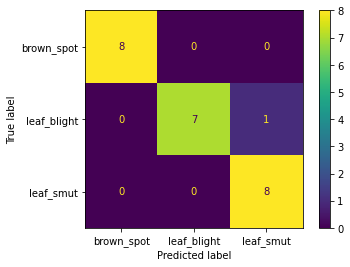

In [13]:
metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(gt_classes, predicted_classes), 
    display_labels=image_classes
).plot()

In [14]:
print(metrics.classification_report(gt_classes, predicted_classes, target_names=image_classes))

              precision    recall  f1-score   support

  brown_spot       1.00      1.00      1.00         8
 leaf_blight       1.00      0.88      0.93         8
   leaf_smut       0.89      1.00      0.94         8

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24



This is pretty good performance!  We nearly got it perfect.  Parameter tuning might make it work even better (although we would need to do a cross-validation to really be sure).